# Import Libraries

In [1]:
# Package Installing
%%capture
!pip install transformers
!pip install --upgrade fastapi typing-extensions
!pip install gradio transformers pillow

In [2]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [3]:
cd /content/Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task

/content/Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task


In [4]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, ViTImageProcessor

import random

import pickle
from PIL import Image
import gradio as gr

from sentiment_analysis_helper_functions import construct_encodings, construct_tfdataset, create_predictor
from image_captioning_helper_functions import get_caption

# Data Preprocessing

In [5]:
senticap_data = pd.read_csv('senticap.csv')

In [6]:
senticap_data.head()

,Unnamed: 0,imgid,split,filename,successful,tokens,word_sentiment,sentiment,raw
0,0,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'delicious', 'food', 'inc...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0]",1,a plate of delicious food including French fries.
1,1,31369,train,COCO_val2014_000000389081.jpg,1,"['french', 'fries', 'are', 'not', 'a', 'health...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",1,French fries are not a healthy food but it is ...
2,2,31369,train,COCO_val2014_000000389081.jpg,1,"['the', 'plate', 'has', 'one', 'of', 'my', 'fa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0,...",1,"The plate has one of my favorite foods on it, ..."
3,3,31369,train,COCO_val2014_000000389081.jpg,1,"['it', 'was', 'disgusting', 'food', 'not', 'ju...","[0.0, 0.0, 1, 1, 0.0, 0.0, 1, 1]",0,"It was disgusting food, not just bad food."
4,4,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'disgusting', 'food', 'fo...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0]",0,A plate of disgusting food found at a diner.


In [7]:
senticap_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39199 entries, 0 to 39198
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      39199 non-null  int64 
 1   imgid           39199 non-null  int64 
 2   split           39199 non-null  object
 3   filename        39199 non-null  object
 4   successful      39199 non-null  int64 
 5   tokens          39199 non-null  object
 6   word_sentiment  39199 non-null  object
 7   sentiment       39199 non-null  int64 
 8   raw             39199 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.7+ MB


In [8]:
senticap_data.nunique()

Unnamed: 0        39199
imgid              2225
split                 3
filename           2225
successful            2
tokens             8636
word_sentiment     1041
sentiment             2
raw                8785
dtype: int64

In [9]:
senticap_data.isna().sum()

Unnamed: 0        0
imgid             0
split             0
filename          0
successful        0
tokens            0
word_sentiment    0
sentiment         0
raw               0
dtype: int64

In [10]:
senticap_data.filename.value_counts()

filename
COCO_val2014_000000389081.jpg    36
COCO_val2014_000000269975.jpg    36
COCO_val2014_000000202653.jpg    36
COCO_val2014_000000445999.jpg    36
COCO_val2014_000000372641.jpg    36
                                 ..
COCO_val2014_000000176034.jpg     1
COCO_val2014_000000218874.jpg     1
COCO_val2014_000000260221.jpg     1
COCO_val2014_000000280464.jpg     1
COCO_val2014_000000108169.jpg     1
Name: count, Length: 2225, dtype: int64

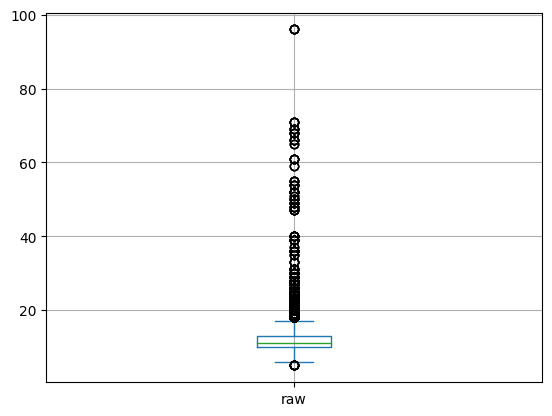

In [11]:
senticap_data['raw'].apply(lambda x : len(x.split())).plot.box(grid = True)
plt.show()

In [12]:
print(*senticap_data[senticap_data.raw.str.split().str.len() > 40]['raw'].unique()[:3],
      sep = '\n' * 2 + '-' * 10 + '\n' * 2)

1. Depicted in this photo is a rather dirty face upclose with a scary tree in the foreground.
2. Just in front of the red stop sign one encounters a crazy face wearing what appears to be glasses.
3. The scary tree on the dangerous road with a partial horrible face makes for a very bad sign or omen.

----------

1.Some healthy baby elephants stand in the dirt among grass trees and a hill.
2/ A couple of curious baby elephants drink water at a watering hole.
3. A baby elephant is seen at the water with two larger elephants drinking tasty water nearby a sunny hill.

----------

1. We waved to the mad cat looking at us through the window grids.
2.Is this a sick cat, a lazy cat or a dumb cat trying to escape the window through the bars the hard way.
3. This crazy cat is peering through the grids looking quite like a sad cat.


In [13]:
inconsist_data = senticap_data[senticap_data.raw.str.split().str.len() > 40].copy()
inconsist_data['filename'].nunique()

16

In [14]:
# Pick randomly one of the captions of each text
senticap_data.loc[inconsist_data.index, 'raw'] = inconsist_data['raw'].apply(lambda x : random.choice(x.split('\n')))

In [15]:
# # Pick randomly one of the captions of each image

# senticap_data2 = senticap_data.groupby('filename').sample(1)[['filename', 'raw', 'sentiment']].reset_index(drop = True).copy()

# # Remove the samples which the filename does not exist in the image folder

# senticap_data2 = pd.DataFrame([values for idx, values in senticap_data2.iterrows() if os.path.exists('senticap_images/' +
                                                                                                    #  values['filename'])]).reset_index(drop = True)

In [16]:
# sentiment analysis data
# senti_data = senticap_data2.iloc[:, 1:].copy()
# senti_data.rename(columns={'raw' : 'text'}, inplace=True)
# senti_data

In [17]:
#@title Save Sentiment Analysis Data
# senti_data.to_csv('senti_data.csv', index=False)

In [18]:
# image caption data
# img_cap_data = senticap_data2.iloc[:, :-1].copy()
# img_cap_data.rename(columns={'filename' : 'image', 'raw' : 'text'}, inplace=True)
# img_cap_data

In [19]:
#@title Save Image Captioning Data
# img_cap_data.to_csv('img_cap_data.csv', index=False)

# Image Captioning - Sentiment Analysis Model

In [20]:
#@title Load Sentiment Analysis Fine-Tuned Model

sentiment_analysis_finetuned_model = TFDistilBertForSequenceClassification.from_pretrained('./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf')
with open('./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf_info.pkl', 'rb') as f:
  model_name, max_len = pickle.load(f)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
sentiment_analysis_clf = create_predictor(sentiment_analysis_finetuned_model, tokenizer, model_name, max_len)

Some layers from the model checkpoint at ./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
#@title Load Image Captioning Fine-Tuned Model

image_captioning_fine_tuned_model = VisionEncoderDecoderModel.from_pretrained('./image_captioning_gen')
image_processor = ViTImageProcessor.from_pretrained('./image_captioning_gen/preprocessor_config.json')
imgcap_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [22]:
#@title Sentiment Analysis / Image Captioning Model

def Senti_Cap(image):

  # Image Captioning
  caption = get_caption(image_captioning_fine_tuned_model,
                        image_processor, imgcap_tokenizer, image)

  # Sentiment Analysis
  sentiment = sentiment_analysis_clf(caption)
  sentiment = 'Positive' if sentiment == 1 else 'Negative'

  return caption, sentiment

# Demo Inference

In [23]:
demo = gr.Interface(fn=Senti_Cap,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption"), gr.Textbox(label="Sentiment")],
                    title="Image Captioning",
                    allow_flagging="never",
                    examples=senticap_data.drop_duplicates(subset=['filename']).filename.sample(2).apply(lambda img_path : os.path.join("senticap_images", img_path)).tolist())

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://833ddc54270565ee2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
demo.close()

Closing server running on port: 7860
